In [24]:
import os
import pandas as pd
import numpy as np

def load_sentiment_word_list(word_list_path):
    try:
        return pd.read_csv(
            word_list_path, 
            sep="\t", 
            comment='#', 
            skip_blank_lines=True
        )
    except Exception as e:
        raise ValueError(f"Error reading word list: {e}")

def load_reviews(folder_path, sample_size=100):
    all_reviews = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                movie_reviews = pd.read_csv(file_path)
                sampled_reviews = movie_reviews.sample(
                    n=sample_size, replace=False, random_state=42
                ) if len(movie_reviews) > sample_size else movie_reviews
                sampled_reviews['movie'] = file_name.replace('.csv', '')
                all_reviews.append(sampled_reviews)
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
    return pd.concat(all_reviews, ignore_index=True)

def compute_sentiment(review, happiness_dict):
    words = review.split()
    scores = [happiness_dict[word.lower()] for word in words if word.lower() in happiness_dict]
    return np.mean(scores) if scores else np.nan

def analyze_sentiments(folder_path, word_list_path, sample_size=100):
    # Load word list and create happiness dictionary
    sentiment_words = load_sentiment_word_list(word_list_path)
    happiness_dict = dict(zip(sentiment_words['word'], sentiment_words['happiness_average']))
    
    # Load reviews and compute sentiment scores
    reviews_data = load_reviews(folder_path, sample_size)
    reviews_data['sentiment_score'] = reviews_data['review'].apply(
        lambda x: compute_sentiment(str(x), happiness_dict)
    )
    reviews_data['sentiment_label'] = reviews_data['sentiment_score'].apply(
        lambda x: 'positive' if x >= 6 else ('negative' if x <= 4 else 'neutral')
    )
    
    # Aggregate sentiment data by movie
    sentiment_summary = reviews_data.groupby('movie').agg(
        avg_sentiment=('sentiment_score', 'mean'),
        positive_count=('sentiment_label', lambda x: (x == 'positive').sum()),
        total_reviews=('review', 'count')
    )
    
    # Sort and extract top/bottom 10 movies
    top_movies = sentiment_summary.sort_values(by='avg_sentiment', ascending=False).head(10)
    bottom_movies = sentiment_summary.sort_values(by='avg_sentiment', ascending=True).head(10)
    
    # Print results
    print("Top 10 Movies with Highest Sentiment Scores:")
    print(top_movies[['avg_sentiment']])
    
    print("\nTop 10 Movies with Lowest Sentiment Scores:")
    print(bottom_movies[['avg_sentiment']])
    
    return top_movies, bottom_movies

# Paths and execution
folder_path = "reviews"  # Replace with your folder path
word_list_path = "labMIT-1.0.txt"    # Replace with your word list path
sample_size = 100
top_movies, bottom_movies = analyze_sentiments(folder_path, word_list_path, sample_size)

Top 10 Movies with Highest Sentiment Scores:
                                                    avg_sentiment
movie                                                            
Coco 2017                                                5.584591
Dangal 2016                                              5.577620
The Greatest Showman 2017                                5.576735
Elf 2003                                                 5.569035
Sing Street 2016                                         5.565084
Toy Story 1995                                           5.561308
The Guernsey Literary and Potato Peel Pie Socie...       5.561288
Walk the Line 2005                                       5.559838
The Wedding Singer 1998                                  5.555443
Eurovision Song Contest: The Story of Fire Saga...       5.554659

Top 10 Movies with Lowest Sentiment Scores:
                        avg_sentiment
movie                                
Stalingrad 1993              5.274520
Alie

In [25]:
import os
import pandas as pd

def create_genre_dataframe_with_genres(folder_path):
    """
    Combine all genre-specific movie files into a single DataFrame, adding genres as a column.
    
    Args:
        folder_path (str): Path to the folder containing genre CSV files.
    
    Returns:
        pd.DataFrame: A DataFrame with two columns: 'genre' and 'name'.
    """
    genre_data = []
    
    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            genre_name = file_name.replace('.csv', '')  # Extract the genre from the filename
            file_path = os.path.join(folder_path, file_name)
            
            try:
                # Load the movie data for this genre
                genre_df = pd.read_csv(file_path)
                if 'name' in genre_df.columns:  # Ensure the 'name' column exists
                    for movie_name in genre_df['name']:
                        # Append each movie along with the genre
                        genre_data.append({'genre': genre_name, 'name': movie_name})
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
    
    # Convert the collected data to a DataFrame
    genre_dataframe = pd.DataFrame(genre_data)
    return genre_dataframe

# Create the updated genre DataFrame with genres
genre_dataframe = create_genre_dataframe_with_genres("1_movies_per_genre")

# Path to the folder containing the genre CSV files
folder_path = "1_movies_per_genre"  # Replace with the actual folder path

# Create the genre DataFrame
genre_dataframe = create_genre_dataframe_with_genres(folder_path)

# Display the first few rows of the resulting DataFrame
print(genre_dataframe.head())

# Save to a CSV file if needed
genre_dataframe.to_csv('genre_dataframe.csv', index=False)


   genre                      name
0  Crime           The Dark Knight
1  Crime              Pulp Fiction
2  Crime             The Godfather
3  Crime                     Se7en
4  Crime  The Silence of the Lambs


In [26]:
import os
import re
import pandas as pd
import networkx as nx
from itertools import combinations

def strip_year_from_title(title):
    """
    Remove the year from the end of a movie title.
    Example: 'The Dark Knight 2008' -> 'The Dark Knight'
    """
    return re.sub(r'\s+\d{4}$', '', title.strip())

def build_movie_network_with_genres(folder_path, word_list_path, genres_df, sample_size=100):
    """
    Build a movie network where nodes are movies (with years stripped),
    edges represent shared reviewers, and genres are added as a node attribute.

    Args:
        folder_path (str): Path to the folder containing movie review CSV files.
        word_list_path (str): Path to the sentiment word list file.
        genres_df (pd.DataFrame): DataFrame with movie names and genres.
        sample_size (int): Number of reviews to sample per movie.

    Returns:
        networkx.Graph: The constructed movie network with genres as a node attribute.
    """
    # Load the sentiment word list
    sentiment_words = pd.read_csv(word_list_path, sep="\t", comment='#', skip_blank_lines=True)
    happiness_dict = dict(zip(sentiment_words['word'], sentiment_words['happiness_average']))

    # Load reviews and process movie titles
    all_reviews = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                movie_reviews = pd.read_csv(file_path)
                # Remove the year from the movie title
                movie_title = strip_year_from_title(file_name.replace('.csv', ''))
                sampled_reviews = movie_reviews.sample(
                    n=sample_size, replace=False, random_state=42
                ) if len(movie_reviews) > sample_size else movie_reviews
                sampled_reviews['movie'] = movie_title
                all_reviews.append(sampled_reviews)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")

    combined_reviews = pd.concat(all_reviews, ignore_index=True)

    # Compute sentiment scores
    def compute_sentiment(review):
        words = review.split()
        scores = [happiness_dict[word.lower()] for word in words if word.lower() in happiness_dict]
        return sum(scores) / len(scores) if scores else None

    combined_reviews['sentiment_score'] = combined_reviews['review'].apply(lambda x: compute_sentiment(str(x)))

    # Compute average sentiment per movie
    avg_sentiment = combined_reviews.groupby('movie')['sentiment_score'].mean().to_dict()

    # Normalize movie names in genres DataFrame
    genres_df['name'] = genres_df['name'].apply(strip_year_from_title).str.strip().str.lower()

    # Normalize movie names in avg_sentiment dictionary
    avg_sentiment = {strip_year_from_title(movie).lower(): score for movie, score in avg_sentiment.items()}

    # Build the graph
    G = nx.Graph()

    # Add nodes with average sentiment and genres as attributes
    for movie, sentiment in avg_sentiment.items():
        genres = genres_df.loc[genres_df['name'] == movie, 'genre'].tolist()
        G.add_node(movie, avg_sentiment=sentiment, genres=genres)

    # Add edges based on shared reviewers
    combined_reviews['movie'] = combined_reviews['movie'].apply(strip_year_from_title).str.strip().str.lower()
    for user, group in combined_reviews.groupby('username'):
        movies_reviewed = group['movie'].tolist()
        for movie1, movie2 in combinations(movies_reviewed, 2):
            if G.has_edge(movie1, movie2):
                G[movie1][movie2]['weight'] += 1
            else:
                G.add_edge(movie1, movie2, weight=1)

    return G

# Example usage
folder_path = "reviews"  # Replace with the folder containing review CSV files
word_list_path = "labMIT-1.0.txt"     # Replace with the sentiment word list file path
#genres_df = create_genre_dataframe("1_movies_per_genre")  # Replace with the actual genre folder path
sample_size = 100                     # Number of reviews to sample per movie

movie_network = build_movie_network_with_genres(folder_path, word_list_path, genre_dataframe, sample_size)

# Inspect the resulting network
print(f"Number of nodes (movies): {movie_network_with_genres.number_of_nodes()}")
print(f"Number of edges (shared reviewers): {movie_network_with_genres.number_of_edges()}")

# Example: Print a few nodes with attributes
for node, data in list(movie_network_with_genres.nodes(data=True))[:5]:
    print(f"Movie: {node}, Avg Sentiment: {data['avg_sentiment']}, Genres: {data['genres']}")


Number of nodes (movies): 1144
Number of edges (shared reviewers): 360594
Movie: 10 cloverfield lane, Avg Sentiment: 5.372524344733121, Genres: ['Horror', 'Mystery']
Movie: 10 things i hate about you, Avg Sentiment: 5.519343679270585, Genres: ['Romance']
Movie: 12 angry men, Avg Sentiment: 5.419904404024088, Genres: ['Crime', 'Drama']
Movie: 12 monkeys, Avg Sentiment: 5.401343413195693, Genres: ['Mystery', 'Sci-Fi', 'Thriller']
Movie: 12 strong, Avg Sentiment: 5.404263299763268, Genres: ['History']


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

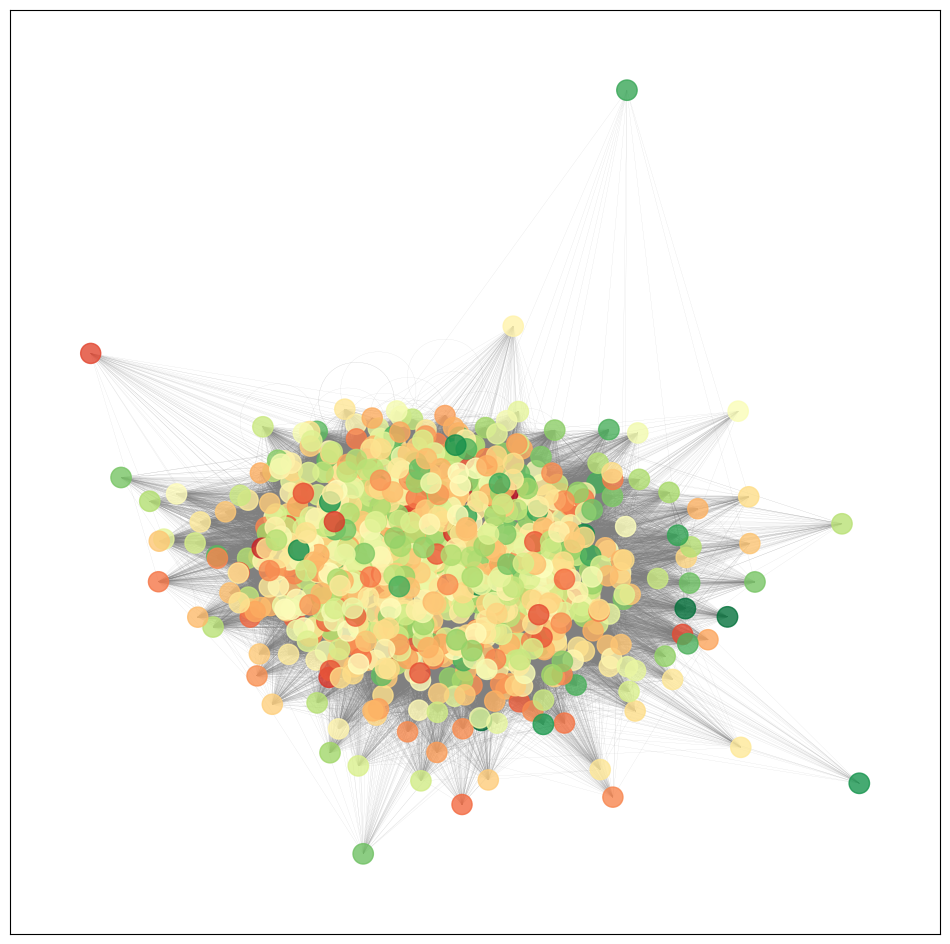

In [27]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_movie_network_no_labels(G):
    """
    Visualize the movie network without movie names.
    Average sentiment is represented by node color, and edge weight is represented by transparency.
    """
    # Extract node attributes for visualization
    node_colors = [data['avg_sentiment'] for _, data in G.nodes(data=True)]
    node_sizes = [50 + (data['avg_sentiment'] or 0) * 30 for _, data in G.nodes(data=True)]  # Scale node size by sentiment
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]  # Use edge weight for transparency

    # Normalize node colors for colormap
    max_sentiment = max(node_colors)
    min_sentiment = min(node_colors)
    norm_node_colors = [(color - min_sentiment) / (max_sentiment - min_sentiment + 1e-5) for color in node_colors]

    # Set up the plot
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Use a spring layout for better visualization

    # Draw nodes with color based on sentiment
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=norm_node_colors,
        cmap=plt.cm.RdYlGn,  # Use a colormap from red (low sentiment) to green (high sentiment)
        node_size=node_sizes,
        alpha=0.8
    )

    # Draw edges with weight as transparency
    nx.draw_networkx_edges(
        G,
        pos,
        width=[weight / max(edge_weights) * 2 for weight in edge_weights],
        alpha=0.6,
        edge_color='gray'
    )

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=min_sentiment, vmax=max_sentiment))
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.7)  # Shrink colorbar to fit plot
    cbar.set_label('Average Sentiment')

    # Set title and display
    plt.title("Movie Network with Average Sentiment as Node Attribute (No Labels)", fontsize=16)
    plt.axis('off')
    plt.show()

# Visualize the movie network without movie names
visualize_movie_network_no_labels(movie_network)


Number of communities detected: 3


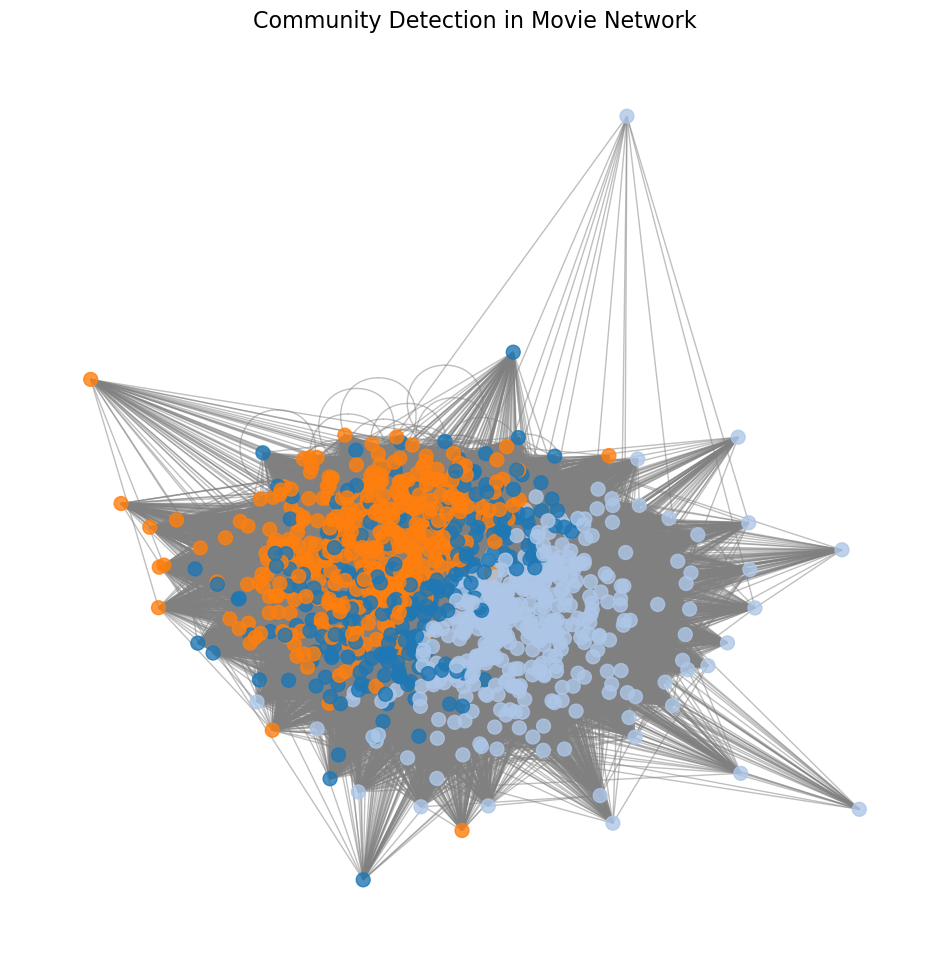

Community 0: 300 movies
Community 1: 416 movies
Community 2: 428 movies


In [32]:
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

def detect_and_visualize_communities(G):
    """
    Detect and visualize communities in the movie network.
    Communities are detected using the Louvain method.
    """
    # Detect communities using the Louvain method
    partition = community_louvain.best_partition(G, weight='weight')

    # Add community as a node attribute
    nx.set_node_attributes(G, partition, 'community')

    # Extract community information
    communities = set(partition.values())
    print(f"Number of communities detected: {len(communities)}")

    # Create a color map for the communities
    community_colors = {community: plt.cm.tab20.colors[i % 20] for i, community in enumerate(communities)}

    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in G.nodes]

    # Visualize the graph with communities
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_colors,
        node_size=100,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color='gray',
        alpha=0.5
    )

    # Add title and legend
    plt.title("Community Detection in Movie Network", fontsize=16)
    plt.axis('off')
    plt.show()

    # Print community assignments for nodes
    for community in communities:
        members = [node for node in G.nodes if partition[node] == community]
        print(f"Community {community}: {len(members)} movies")

    return partition

# Run community detection and visualize
partition = detect_and_visualize_communities(movie_network)


Sentiment Summary by Community:
   community  avg_sentiment  sentiment_std  movie_count
0          0       5.422396       0.053079          300
1          1       5.427338       0.055072          416
2          2       5.427529       0.055082          428


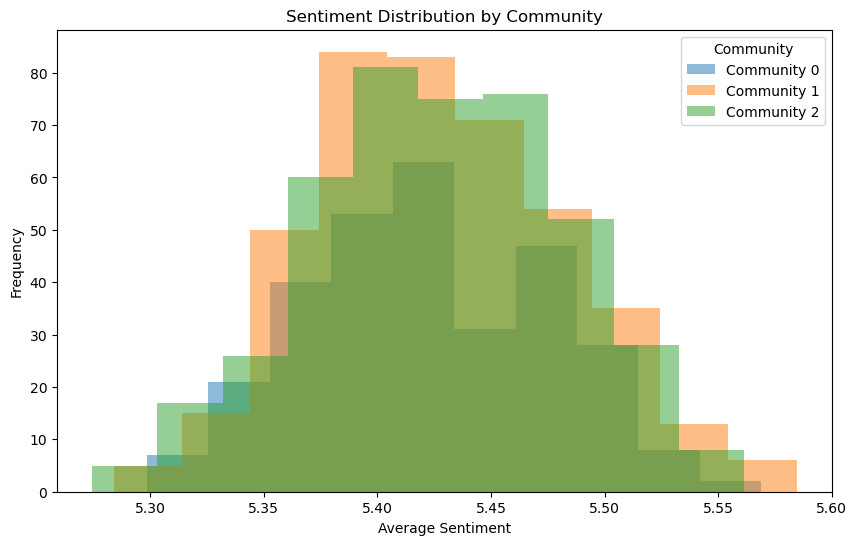

In [33]:
def analyze_sentiment_by_community(G, partition):
    """
    Analyze sentiment distributions within each community.
    
    Args:
        G (networkx.Graph): The movie network with average sentiment as a node attribute.
        partition (dict): Community assignments for each node.

    Returns:
        pd.DataFrame: Summary of sentiment distributions for each community.
    """
    # Create a DataFrame to hold community and sentiment information
    community_data = []
    for node, community in partition.items():
        avg_sentiment = G.nodes[node].get('avg_sentiment', None)
        if avg_sentiment is not None:
            community_data.append({'community': community, 'movie': node, 'avg_sentiment': avg_sentiment})
    
    community_df = pd.DataFrame(community_data)

    # Calculate sentiment statistics for each community
    sentiment_summary = community_df.groupby('community').agg(
        avg_sentiment=('avg_sentiment', 'mean'),
        sentiment_std=('avg_sentiment', 'std'),
        movie_count=('movie', 'count')
    ).reset_index()

    # Print sentiment summary for each community
    print("Sentiment Summary by Community:")
    print(sentiment_summary)

    # Plot the sentiment distributions for communities
    plt.figure(figsize=(10, 6))
    for community, group in community_df.groupby('community'):
        plt.hist(
            group['avg_sentiment'], 
            bins=10, 
            alpha=0.5, 
            label=f'Community {community}'
        )
    plt.title("Sentiment Distribution by Community")
    plt.xlabel("Average Sentiment")
    plt.ylabel("Frequency")
    plt.legend(title="Community")
    plt.show()

    return sentiment_summary

# Analyze sentiment by community
sentiment_summary = analyze_sentiment_by_community(movie_network, partition)


Genre Dominance by Community:
    community      genre  count  proportion
0           0     Action     27    0.062791
1           0  Adventure     21    0.048837
2           0  Animation     27    0.062791
3           0  Biography     22    0.051163
4           0     Comedy     23    0.053488
5           0      Crime     25    0.058140
6           0      Drama     20    0.046512
7           0    Fantasy     28    0.065116
8           0    History     27    0.062791
9           0     Horror     27    0.062791
10          0      Music     26    0.060465
11          0    Mystery     29    0.067442
12          0    Romance     33    0.076744
13          0     Sci-Fi     24    0.055814
14          0      Sport     29    0.067442
15          0   Thriller     27    0.062791
16          0        War     15    0.034884
17          1     Action     47    0.072419
18          1  Adventure     50    0.077042
19          1  Animation     38    0.058552
20          1  Biography     51    0.078582
21

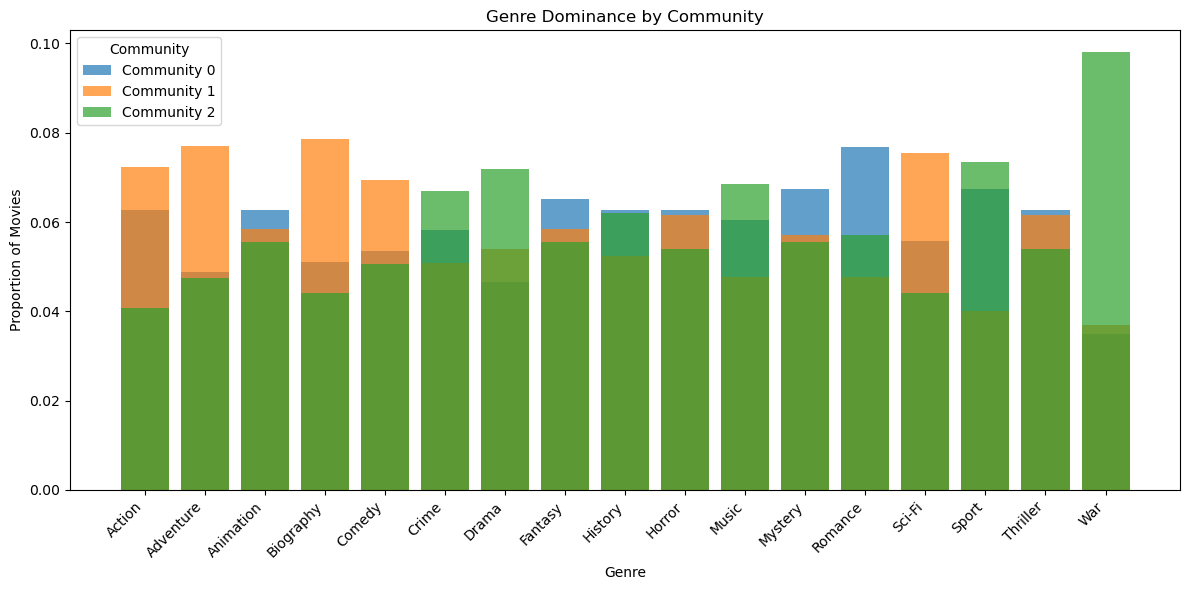

In [36]:
def analyze_genre_dominance_by_community(G, partition, genres_df):
    """
    Analyze genre dominance within communities, assuming a single genre per movie.

    Args:
        G (networkx.Graph): The movie network with communities detected.
        partition (dict): Community assignments for each node in the network.
        genres_df (pd.DataFrame): DataFrame containing movie names and genres.

    Returns:
        pd.DataFrame: A summary of genre distributions within each community.
    """
    # Create a DataFrame for movie-to-community mapping
    community_data = []
    for node, community in partition.items():
        community_data.append({'movie': node, 'community': community})
    
    community_df = pd.DataFrame(community_data)

    # Merge the movie-to-community mapping with the genres
    merged_df = pd.merge(community_df, genres_df, left_on='movie', right_on='name', how='inner')

    # Count the number of movies per genre in each community
    genre_summary = merged_df.groupby(['community', 'genre']).size().reset_index(name='count')

    # Calculate the total number of movies per community
    total_counts = genre_summary.groupby('community')['count'].transform('sum')

    # Calculate the proportion of each genre within the community
    genre_summary['proportion'] = genre_summary['count'] / total_counts

    # Display the genre dominance summary
    print("Genre Dominance by Community:")
    print(genre_summary)

    # Plot the genre proportions for each community
    plt.figure(figsize=(12, 6))
    communities = genre_summary['community'].unique()
    for community in communities:
        community_data = genre_summary[genre_summary['community'] == community]
        plt.bar(
            community_data['genre'],
            community_data['proportion'],
            alpha=0.7,
            label=f'Community {community}'
        )

    plt.title("Genre Dominance by Community")
    plt.xlabel("Genre")
    plt.ylabel("Proportion of Movies")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Community")
    plt.tight_layout()
    plt.show()

    return genre_summary


genre_dominance_summary = analyze_genre_dominance_by_community(movie_network, partition, genre_dataframe)
